<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.0.8


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [8]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.fit(train_df)

In [9]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)
jan20_forecast = forecast[forecast['ds'] == '2016-01-20']
print('20 Jan: ', round(jan20_forecast['yhat'].tolist()[0]))

20 Jan:  3833


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

**Ответ:** 3833

Оценим качество предсказания по последним 30 точкам.

In [10]:
import numpy as np

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']

print('MAPE:', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE: ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE: 38.3808048352
MAE:  712.856684675


**Вопрос 2**: Какое получилось MAPE?

**Ответ:** 38.38

**Вопрос 3**: Какое получилось MAE?

**Ответ:** 713

## Предсказываем с помощью ARIMA

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs

from sklearn.metrics import mean_absolute_error, mean_squared_error

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

Критерий Дики-Фуллера: p=0.107392
Есть единичные корни, ряд не стационарен.


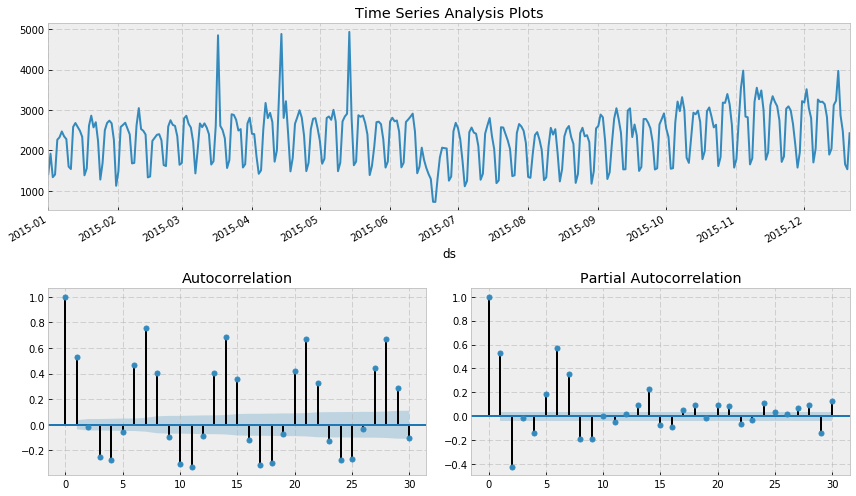

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        adf_test = sm.tsa.stattools.adfuller(y)
        print("Критерий Дики-Фуллера: p=%f" % adf_test[1])
        if adf_test[0] > adf_test[4]['5%']: 
            print('Есть единичные корни, ряд не стационарен.')
        else:
            print('Единичных корней нет, ряд стационарен.')

        plt.tight_layout()
    return 

tsplot(train_df.set_index('ds')['y'], lags=30)

Критерий Дики-Фуллера: p=0.116981
Есть единичные корни, ряд не стационарен.
Оптимальный параметр преобразования Бокса-Кокса: 0.732841


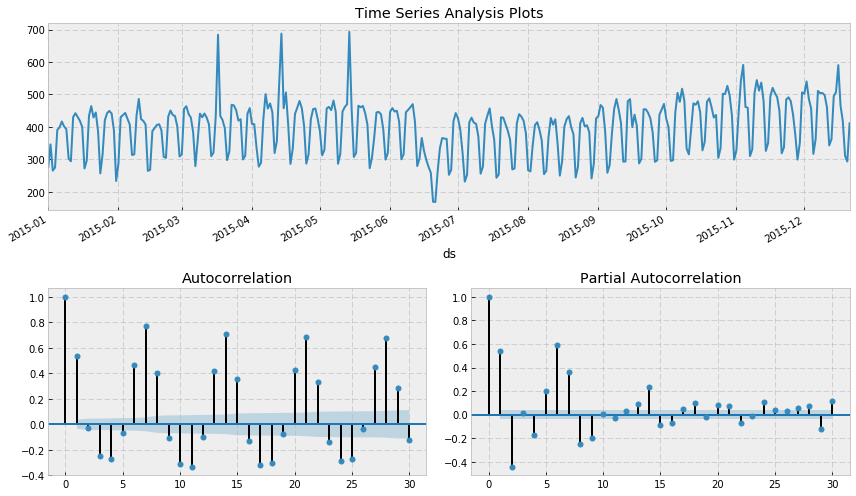

In [13]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = train_df.set_index('ds').copy()
data['y_box'], lmbda = scs.boxcox(data['y'])
tsplot(data.y_box, lags=30)

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000
Единичных корней нет, ряд стационарен.


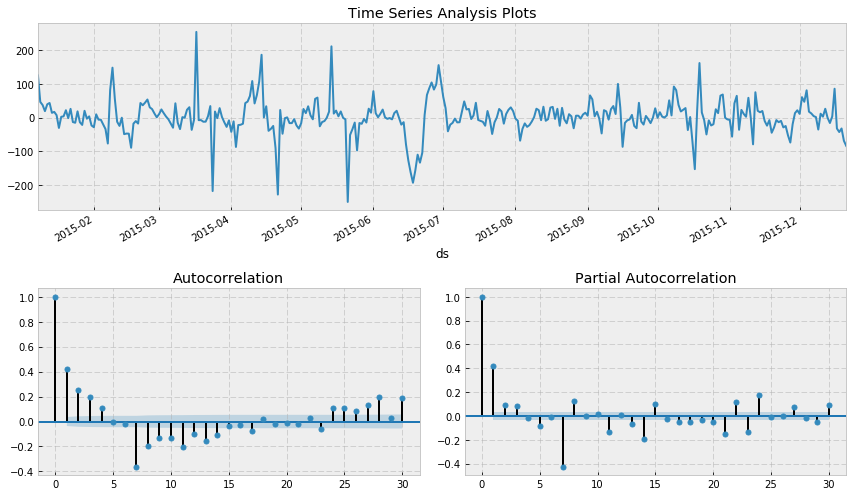

In [14]:
data['y_box_season'] = data.y_box - data.y_box.shift(7)
tsplot(data.y_box_season[7:], lags=30)

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [15]:
D = range(0, 3)
d = range(0, 2)
Q = range(0, 2)
q = 2
P = 3
p = 1

from itertools import product

parameters = product(D, d, Q)
parameters_list = list(parameters)
len(parameters_list)

12

In [16]:
%%time
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(data.y_box, order=(p, param[1], q), 
                                        seasonal_order=(P, param[0], param[2], 7)).fit(disp=-1)
    except Exception:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|          | 0/12 [00:00<?, ?it/s]

wrong parameters: (0, 0, 0)
wrong parameters: (0, 0, 1)
wrong parameters: (0, 1, 0)
wrong parameters: (0, 1, 1)


100%|██████████| 12/12 [00:32<00:00,  4.50s/it]

  parameters          aic
5  (2, 0, 1)  3528.650844
7  (2, 1, 1)  3534.570948
0  (1, 0, 0)  3556.880030
1  (1, 0, 1)  3557.003104
3  (1, 1, 1)  3557.952362
CPU times: user 29.5 s, sys: 1.17 s, total: 30.6 s
Wall time: 32.4 s


In [17]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.y_box, order=(p, 0, q), seasonal_order=(P, 2, 1, 7)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, 1, 7)   Log Likelihood               -1756.325
Date:                           Mon, 15 May 2017   AIC                           3528.651
Time:                                   18:40:56   BIC                           3559.583
Sample:                               01-01-2015   HQIC                          3540.959
                                    - 12-21-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8194      0.118      6.958      0.000       0.589       1.050
ma.L1         -0.3353      0.124     -2.702

Критерий Дики-Фуллера: p=0.000000
Единичных корней нет, ряд стационарен.


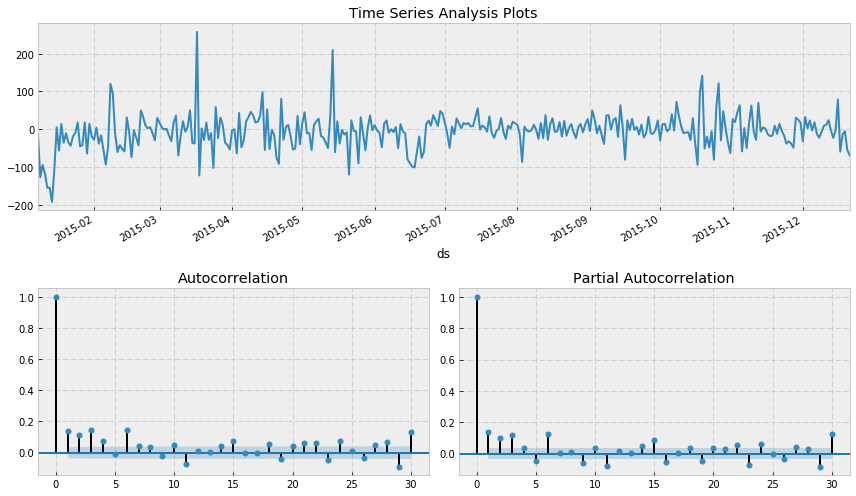

In [18]:
tsplot(best_model.resid[7:], lags=30)

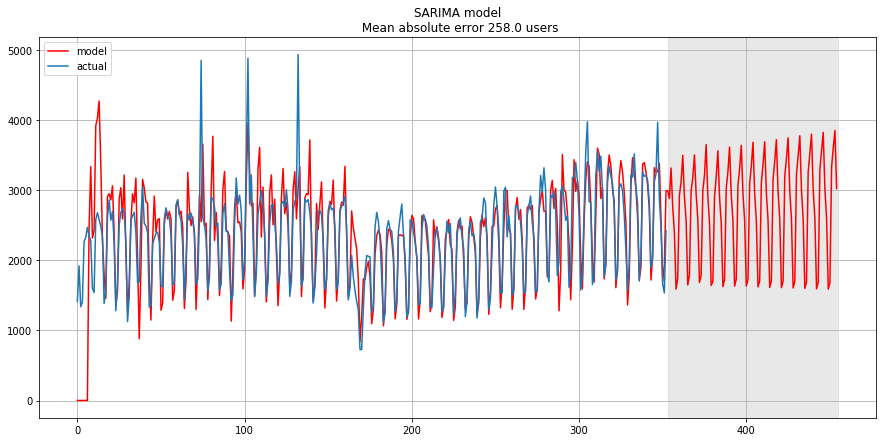

In [19]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)

forecast = invboxcox(best_model.predict(start = data.shape[0] - 1, end = data.shape[0] + 100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.y.values[-400:]

plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().y, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)